---
title: Data Production Notebook
short_title: Data Production Notebook
description: |
    This notebook downloads the source data, runs the full processing workflow, and saves all figures and outputs (including GeoJSON and Zarr) for interactive visualization
---

In [1]:
import pooch
import zipfile
import pathlib

# Shared Dropbox folder link, converted to direct download
# url = "https://www.dropbox.com/scl/fo/ew332zqzkk9ngfjpn7vjp/ABi8WCIy_HfM63Kd_xT4gXg?rlkey=16njkqecnp5wgjflmlh29g7ww&dl=1"
url = "https://cdn.curvenote.com/static/agu-recharge-2025-temp/central_valley_aem_recharge.zip"

# Create a Pooch object and register the file
p = pooch.create(
    path=pooch.os_cache("em_recharge"),
    base_url="",
    registry={
        "folder_data.zip": None  # No hash verification
    },
    urls={
        "folder_data.zip": url  # Map the file to its URL
    },
)

# Fetch the file
zip_path = p.fetch("folder_data.zip")

# Extract to a local directory
# extract_dir = pathlib.Path(p.abspath) / "data_download"
extract_dir = pathlib.Path("./data_download")
extract_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted contents to {extract_dir}")

Extracted contents to data_download


# Data Acquisition & Loading

This section downloads the source data and loads all necessary datasets including AEM resistivity measurements, rock physics relationships, bedrock depth, and water table data.


In [2]:
from emrecharge.datasets import EMDataset
import numpy as np
import geopandas as gpd
import dill
import rioxarray  # noqa: F401
import matplotlib.pyplot as plt
from discretize import TensorMesh
from scipy.spatial import cKDTree as kdtree
from SimPEG.utils import rotate_points_from_normals
from SimPEG import utils
from verde import distance_mask
import pandas as pd
import numpy.ma as ma
from matplotlib.colors import LogNorm
from scipy.interpolate import NearestNDInterpolator
from discretize.utils import mesh_builder_xyz
import matplotlib


def rotate_vector(xy, invert=False):
    x0_max = 128989.96617666919
    y0_min = -344621.31282856315
    if invert:
        xy_norm = np.c_[xy[:, 0], xy[:, 1], np.zeros_like(xy[:, 0])]
        xy_norm_rot = rotate_points_from_normals(
            xy_norm, np.array([0, 1, 0]), np.array([-352306.81278939766, 643151.2476351159, 0])
        )
        xy_norm_rot[:, 0] += x0_max
        xy_norm_rot[:, 1] += y0_min
    else:
        xy_norm = np.c_[xy[:, 0] - x0_max, xy[:, 1] - y0_min, np.zeros_like(xy[:, 0])]
        xy_norm_rot = rotate_points_from_normals(
            xy_norm, np.array([-352306.81278939766, 643151.2476351159, 0]), np.array([0, 1, 0])
        )
    return xy_norm_rot[:, :2]

## Load AEM resistivity data

Load the airborne electromagnetic (AEM) resistivity data and Central Valley boundary shapefile. The AEM data contains resistivity measurements at multiple depths, which will be used to infer subsurface sediment properties.

In [3]:
gdf_cv = gpd.read_file(f"{extract_dir}/data/shp/cv/cv.shp")
gdf_cv_3310 = gdf_cv.to_crs(3310)
SPATIAL_UNIT = "m"
em_data = EMDataset(
    f"{extract_dir}/data/aem/em_resistivity.csv",
    f"{extract_dir}/data/aem/thickness.csv",
    SPATIAL_UNIT,
)

## Select resistivity values and rotate coordinates

Select active AEM soundings and rotate coordinates to align with the study region. The rotation transforms coordinates to a standardized orientation for consistent spatial analysis.

In [4]:
hz_aem = em_data.hz
hz_uniform = np.ones(60) * 2.0
mesh_1d_aem = TensorMesh([hz_aem])
mesh_1d_uniform = TensorMesh([hz_uniform])
P_1d = mesh_1d_aem.get_interpolation_matrix(mesh_1d_uniform.cell_centers)
inds_aem_active = np.load(f"{extract_dir}/data/inds_active_aem.npy")
RHO = em_data.resistivity
xy_aem = em_data.xy
RHO_ACTIVE = RHO[inds_aem_active, :]
xy_aem_active = xy_aem[inds_aem_active, :]
xy_aem_rot = rotate_vector(xy_aem)
xy_aem_active_rot = rotate_vector(xy_aem_active)

## Load rock physics relationship between resistivity and sediment type

Load pre-computed rock physics relationships that map resistivity values to sediment type. These relationships define the resistivity ranges for fine-grained (low permeability) and coarse-grained (high permeability) sediments, which are essential for converting resistivity measurements to permeability estimates.

In [5]:
results_rock_physics_grid = dill.load(open(f"{extract_dir}/data/rock_physics_grid.pik", "rb"))
mesh = results_rock_physics_grid["mesh"]
mesh_coarse = results_rock_physics_grid["mesh_coarse"]
rho_fine_cv_grid_idw = results_rock_physics_grid["rho_fine_cv_grid_idw"]
rho_coarse_cv_grid_idw = results_rock_physics_grid["rho_coarse_cv_grid_idw"]
wt_idw = results_rock_physics_grid["wt_idw"]
xy_grid_coarse_rot = results_rock_physics_grid["xy_grid_coarse_rot"]

In [6]:
f_rho_fine = NearestNDInterpolator(mesh_coarse.cell_centers, rho_fine_cv_grid_idw)
f_rho_coarse = NearestNDInterpolator(mesh_coarse.cell_centers, rho_coarse_cv_grid_idw)
rho_fine_cv_mesh = f_rho_fine(mesh.cell_centers)
rho_coarse_cv_mesh = f_rho_coarse(mesh.cell_centers)
rho_fine_cv_aem = f_rho_fine(xy_aem_rot)
rho_coarse_cv_aem = f_rho_coarse(xy_aem_rot)

## Define the region of interest

Load bedrock depth data and define the spatial extent of the study region. The bedrock boundary and water table information will be used to create a base surface that represents the bottom of the aquifer system.

In [7]:
df_bedrock = pd.read_csv(f"{extract_dir}/data/bedrock_depth_int.csv")
gdf_bedrock_boundary = gpd.read_file(
    f"{extract_dir}/data/shp/bedrock_boundary/bedrock_boundary.shp"
)
xy_bedrock_int = df_bedrock[["UTMX", "UTMY"]].values

In [8]:
# Set the grid cell size to be 400 m x 400 m
mesh_orig = mesh_builder_xyz(
    xy_aem[:, :2], [400, 400], padding_distance=[[4000, 4000], [4000, 4000]], expansion_factor=1
)
# mesh_orig.write_UBC('mesh_orig.msh')
xy_grid = mesh.cell_centers
xy_grid_orig = mesh_orig.cell_centers
xy_grid_rot = rotate_vector(xy_grid, invert=True)
xy_bedrock_int_rot = rotate_vector(xy_bedrock_int, invert=False)

In [9]:
# Water table
f_gse_wse = NearestNDInterpolator(xy_grid_rot, wt_idw.data)
depth_aem_center = mesh_1d_aem.cell_centers
# Bedrock depth
f_bedrock = NearestNDInterpolator(xy_bedrock_int, df_bedrock["BEDROCK_DEPTH_M"].values)

In [10]:
geoms_pts_orig = gpd.points_from_xy(xy_grid_orig[:, 0], xy_grid_orig[:, 1])
gdf_grid_orig = gpd.GeoDataFrame(data={}, geometry=geoms_pts_orig, crs=3310)
gdf_grid_orig_clip = gdf_grid_orig.clip(gdf_bedrock_boundary)
inds_bedrock = np.array(list(gdf_grid_orig_clip.index))
base_int_orig = f_gse_wse(xy_grid_orig)
values_bedrock = f_bedrock(xy_grid_orig[inds_bedrock, :])
base_int_orig[inds_bedrock] = values_bedrock
f_base = NearestNDInterpolator(xy_grid_orig, base_int_orig)
base_int = f_base(xy_grid_rot)
base_int = np.clip(base_int, 3, 110)
base_int = ma.masked_array(base_int, mask=wt_idw.mask)

# Base Surface Creation

Create a base surface that represents the bottom of the aquifer system by combining water table elevation and bedrock depth information. This surface defines the lower boundary for all subsequent 3D modeling and metric calculations.

In [11]:
xy_grid = mesh.cell_centers
tree = kdtree(xy_aem_rot)
k_nearest_points = 100
d, inds_idw = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.0
w = 1.0 / ((d + epsilon) ** power)
mask_inds = ~distance_mask(
    (xy_aem_rot[:, 0], xy_aem_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid[:, 0], xy_grid[:, 1]),
)

In [12]:
tree = kdtree(xy_aem_active_rot)
k_nearest_points = 100
d_active, inds_idw_active = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.0
w_active = 1.0 / ((d_active + epsilon) ** power)
mask_inds__active = ~distance_mask(
    (xy_aem_active_rot[:, 0], xy_aem_active_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid[:, 0], xy_grid[:, 1]),
)

In [13]:
tree = kdtree(xy_grid)
k_nearest_points = 100
d_grid, inds_idw_grid = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 0.0
w_grid = 1.0 / ((d_grid + epsilon) ** power)

In [14]:
values = base_int.data.copy()
base_int_idw = np.sum(w_grid * values[inds_idw_grid], axis=1) / np.sum(w_grid, axis=1)
base_aem = f_base(xy_aem)

In [15]:
Z = np.tile(depth_aem_center, (em_data.num_soundings, 1))
Z_base = np.tile(base_aem, (30, 1)).T
HZ = np.tile(hz_aem, (em_data.num_soundings, 1))
HZ[Z > Z_base] = 0.0
RHO_ABOVE = RHO.copy()
SIGMA_ABOVE = 1.0 / RHO_ABOVE
SIGMA_ABOVE[Z > Z_base] = 0.0
RHO_ABOVE[Z > Z_base] = 0.0
rho_avg = 1.0 / ((SIGMA_ABOVE * HZ).sum(axis=1) / HZ.sum(axis=1))
values = rho_avg.copy()
values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
values_idw = ma.masked_array(values_idw, mask=mask_inds)
rho_avg_idw = values_idw.copy()
# aem_rho_avg_dict = {'rho_avg':rho_avg, 'xy': xy_aem}
# dill.dump(aem_rho_avg_dict, open("aem_rho_avg_dict.pik", "wb"))

/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/399678512.py:9: RuntimeWarning: invalid value encountered in divide
  rho_avg = 1.0 / ((SIGMA_ABOVE * HZ).sum(axis=1) / HZ.sum(axis=1))


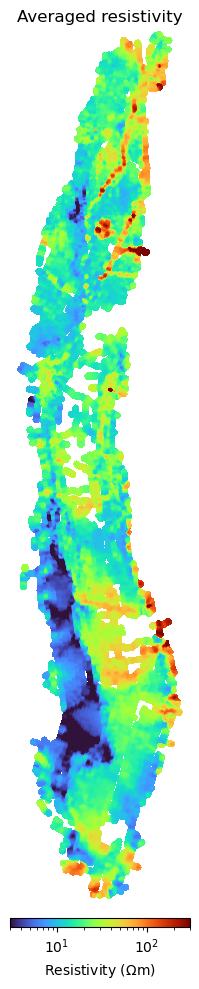

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3, 10))
out = mesh.plot_image(
    rho_avg_idw, ax=ax, pcolor_opts={"norm": LogNorm(vmin=3, vmax=300), "cmap": "turbo"}
)
ax.axis("off")

ax.set_aspect(1)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.01, pad=0.02)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_title("Averaged resistivity")
plt.tight_layout()
# fig.savefig('avg_rho.png', dpi=300)

# 3D Resistivity Model Construction

Interpolate the sparse AEM resistivity measurements into a continuous 3D model using inverse distance weighting (IDW). The model uses a regular grid with 400m × 400m horizontal cells and 2m vertical layers, providing a comprehensive representation of subsurface resistivity distribution.

In [17]:
RHO_ABOVE_nan = RHO_ABOVE.copy()
RHO_ABOVE_nan[RHO_ABOVE == 0.0] = np.nan

In [18]:
RHO_INT = np.zeros((mesh.n_cells, len(hz_aem)))
for i_layer in range(len(hz_aem)):
    values = RHO[:, i_layer].copy()
    values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
    values_idw = ma.masked_array(values_idw, mask=mask_inds__active)
    RHO_INT[:, i_layer] = values_idw
RHO_INT_uniform = RHO_INT * P_1d.T

In [19]:
# RHO_INT_uniform = 1./((1./RHO_INT) * P_1d.T)
# RHO_INT_uniform = RHO_INT * P_1d.T
Z3D = np.tile(mesh_1d_uniform.cell_centers, (mesh.n_cells, 1))
BASE3D = np.tile(base_int.data, (60, 1)).T
INDS3D = Z3D > BASE3D
# RHO_INT_uniform[INDS3D] = np.nan
# RHO_INT_uniform[mask_inds,:] = np.nan

In [20]:
base_inds_3d = INDS3D[:, ::-1].copy()
base_inds_3d[mask_inds, :] = True
base_inds_3d = base_inds_3d.flatten(order="F")
mask_3d = np.tile(mask_inds__active, (60, 1))

base_inds_3d_active = INDS3D[:, ::-1].copy()
base_inds_3d_active[mask_inds__active, :] = True
base_inds_3d_active = base_inds_3d.flatten(order="F")


mask_3d_final = np.logical_or(mask_3d.flatten(), base_inds_3d_active)

rho_int_uniform_simpeg = RHO_INT_uniform[:, ::-1].flatten(order="F")
rho_int_uniform_simpeg = ma.masked_array(rho_int_uniform_simpeg, mask=mask_3d_final)

In [21]:
mesh_3d = TensorMesh(
    [mesh.h[0], mesh.h[1], hz_uniform], x0=[mesh.x0[0], mesh.x0[1], -np.sum(hz_uniform)]
)

# Resistivity to Sediment Type Transformation

Convert resistivity values to Fraction Coarse-Dominated (FCD), which represents the proportion of coarse-grained, high-permeability sediments. This transformation uses the rock physics relationships to map resistivity to sediment type, enabling permeability-based analysis of recharge potential.

In [22]:
def from_sigma_to_fraction(sigma, sigma_fine, sigma_coarse):
    sigma_bounded = sigma.copy()
    sigma_bounded[sigma >= sigma_fine] = sigma_fine
    sigma_bounded[sigma <= sigma_coarse] = sigma_coarse
    fraction_coarse = (sigma_fine - sigma_bounded) / (sigma_fine - sigma_coarse)
    return fraction_coarse

In [23]:
SIGMA = 1.0 / RHO.copy()

In [24]:
FCD = np.zeros_like(RHO_ABOVE)

In [25]:
nxy = 349 * 1773
nz = 60

In [26]:
SIGMA_3D = 1.0 / rho_int_uniform_simpeg.data.reshape((nxy, nz), order="F")
FCD_3D = np.zeros_like(SIGMA_3D)

In [27]:
for ii in range(nxy):
    FCD_3D[ii, :] = from_sigma_to_fraction(
        SIGMA_3D[ii, :], 1.0 / rho_fine_cv_mesh[ii], 1.0 / rho_coarse_cv_mesh[ii]
    )
fcd_int_uniform_simpeg = ma.masked_array(FCD_3D.flatten(order="F"), mask=mask_3d_final)

# Recharge Metric Calculation

Calculate key metrics that quantify recharge suitability using the Fast Marching Method (FMM). These metrics include:

- **Path length**: The distance water travels through high-permeability zones from recharge sources
- **Normalized path length**: Path length relative to a reference case, indicating recharge efficiency
- **Depth to shallowest low-K layer**: The depth to the first low-permeability barrier that could impede recharge

These metrics are calculated for multiple FCD thresholds (10%, 20%, 50%, 80%, 90%) to assess recharge potential under different sediment composition scenarios.

In [28]:
FCD3D = fcd_int_uniform_simpeg.data.reshape((nxy, nz), order="F")
HZ = np.ones_like(fcd_int_uniform_simpeg.data) * 2.0
HZ[mask_3d_final] = 0.0
HZ = HZ.reshape((nxy, nz), order="F")
tmp = (FCD3D * HZ).sum(axis=1) / (HZ).sum(axis=1)
tmp = ma.masked_array(tmp, mask=mask_inds__active)
fc_idw = ma.masked_array(tmp, mask=mask_inds__active)

/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/1887861760.py:5: RuntimeWarning: invalid value encountered in divide
  tmp = (FCD3D * HZ).sum(axis=1) / (HZ).sum(axis=1)


In [29]:
def calcluate_vertical_average(
    model, model_mask_3d, model_mask_2d, bottom, top, average_type="arithmetic"
):
    nxy = 349 * 1773
    nz = 60
    ind_z = np.logical_and(mesh_3d.vectorCCz > -bottom, mesh_3d.vectorCCz < -top)
    MOD = model.reshape((nxy, nz), order="F")[:, ind_z]
    MASK = model_mask_3d.copy().reshape((nxy, nz), order="F")[:, ind_z]
    HZ = np.ones_like(MOD) * 2.0
    HZ[MASK] = 0.0
    HZ = HZ.reshape((nxy, ind_z.sum()), order="F")
    if average_type == "arithmetic":
        avg = (MOD * HZ).sum(axis=1) / (HZ).sum(axis=1)
    elif average_type == "harmonic":
        avg = 1.0 / ((1.0 / MOD * HZ).sum(axis=1) / (HZ).sum(axis=1))
    else:
        raise Exception()
    avg = ma.masked_array(avg, mask=model_mask_2d)
    return avg

In [30]:
# mesh_3d.write_vtk('3d_models.vtr', models={'rho':rho_int_uniform_simpeg.data, 'mask': rho_int_uniform_simpeg.mask.astype(int), 'fcd':fcd_int_uniform_simpeg.data, 'mask_active': fcd_int_uniform_simpeg.mask.astype(int)})

In [31]:
from emrecharge.metrics import classify_cf, get_ready_for_fmm, run_fmm, get_distance_to_first_lowK

In [32]:
xyz_base = np.c_[xy_grid, base_int_idw]
mesh_fmm, inds_source = get_ready_for_fmm(mesh_3d, xyz_base)

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1017: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1034: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1051: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


In [33]:
xy_grid_fmm = utils.ndgrid(mesh_fmm.cell_centers_x, mesh_fmm.cell_centers_y)
gdf_basins_3310_cv = gpd.read_file(f"{extract_dir}/data/shp/subbasins_cv_clip.geojson")
xy_grid_fmm_rot = rotate_vector(xy_grid_fmm, invert=True)

In [34]:
# gdf_cv_3310_buffer = gdf_cv_3310.buffer(3000)
geoms = gpd.points_from_xy(xy_grid_rot[:, 0], xy_grid_rot[:, 1])
gdf_pts_grid_cv = gpd.GeoDataFrame(data={}, geometry=geoms, crs=3310)
gdf_pts_grid_clip_cv = gdf_pts_grid_cv.clip(gdf_cv_3310)
inds_active_cv = list(gdf_pts_grid_clip_cv.index)
inds_active_cv_bool = np.zeros(mesh.n_cells, dtype=bool)
inds_active_cv_bool[inds_active_cv] = True

In [35]:
# gdf_pts_grid_fmm_cv = gdf_pts_grid_fmm.clip(gdf_cv_3310)
# inds_active_fmm_cv = list(gdf_pts_grid_fmm_cv.index)
# inds_active_fmm_cv_bool = np.zeros(351*1775, dtype=bool)
# inds_active_fmm_cv_bool[inds_active_fmm_cv] = True

In [36]:
tree = kdtree(xy_grid_fmm_rot)
k_nearest_points = 100
d_active, inds_idw_active = tree.query(xy_grid, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.0
w_active = 1.0 / ((d_active + epsilon) ** power)
mask_inds_active_fmm = ~distance_mask(
    (xy_aem_active_rot[:, 0], xy_aem_active_rot[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_fmm[:, 0], xy_grid_fmm[:, 1]),
)

In [37]:
geoms = gpd.points_from_xy(xy_grid_fmm_rot[:, 0], xy_grid_fmm_rot[:, 1])
gdf_pts_grid_fmm = gpd.GeoDataFrame(data={}, geometry=geoms, crs=3310)
gdf_pts_grid_fmm_bedrock = gdf_pts_grid_fmm.clip(gdf_bedrock_boundary)
inds_active_source_bedrock_fmm = list(gdf_pts_grid_fmm_bedrock.index)
inds_active_source_fmm_bedrock_bool = np.zeros(351 * 1775, dtype=bool)
inds_active_source_fmm_bedrock_bool[inds_active_source_bedrock_fmm] = True

In [38]:
IND_SOURCE = inds_source.copy().reshape((351 * 1775, 61), order="F")
IND_SOURCE[inds_active_source_fmm_bedrock_bool, :] = False
IND_SOURCE[mask_inds_active_fmm, :] = False
ind_source_final = IND_SOURCE.flatten(order="F")

In [39]:
threshold = 0.1
binary_model_10 = classify_cf(fcd_int_uniform_simpeg.data, threshold)

threshold = 0.2
binary_model_20 = classify_cf(fcd_int_uniform_simpeg.data, threshold)

threshold = 0.5
binary_model_50 = classify_cf(fcd_int_uniform_simpeg.data, threshold)

threshold = 0.8
binary_model_80 = classify_cf(fcd_int_uniform_simpeg.data, threshold)

threshold = 0.9
binary_model_90 = classify_cf(fcd_int_uniform_simpeg.data, threshold)

binary_model_ref = np.ones_like(binary_model_10)

xyz_base_neg = np.c_[xy_grid, -base_int_idw]
inds_below_base = utils.surface2ind_topo(mesh_3d, xyz_base_neg)
binary_model_ref[inds_below_base] = 0.0
binary_model_10[inds_below_base] = 0.0
binary_model_20[inds_below_base] = 0.0
binary_model_50[inds_below_base] = 0.0
binary_model_80[inds_below_base] = 0.0
binary_model_90[inds_below_base] = 0.0

In [40]:
path_length_10 = run_fmm(binary_model_10, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_20 = run_fmm(binary_model_20, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_50 = run_fmm(binary_model_50, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_80 = run_fmm(binary_model_80, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_90 = run_fmm(binary_model_90, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_10 = ma.masked_array(path_length_10, mask=mask_inds__active)
path_length_20 = ma.masked_array(path_length_20, mask=mask_inds__active)
path_length_50 = ma.masked_array(path_length_50, mask=mask_inds__active)
path_length_80 = ma.masked_array(path_length_80, mask=mask_inds__active)
path_length_90 = ma.masked_array(path_length_90, mask=mask_inds__active)

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1017: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1034: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/base/base_tensor_mesh.py:1051: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


In [41]:
path_length_ref = run_fmm(binary_model_ref, mesh_fmm, ind_source_final, vel_ratio=None)
path_length_ref = np.clip(path_length_ref, 0, 120)
path_length_ref = ma.masked_array(path_length_ref, mask=mask_inds__active)

In [42]:
path_length_10_norm = path_length_10.data / path_length_ref.data
path_length_10_norm = ma.masked_array(path_length_10_norm, mask=mask_inds__active)

path_length_20_norm = path_length_20.data / path_length_ref.data
path_length_20_norm = ma.masked_array(path_length_20_norm, mask=mask_inds__active)

path_length_50_norm = path_length_50.data / path_length_ref.data
path_length_50_norm = ma.masked_array(path_length_50_norm, mask=mask_inds__active)

path_length_80_norm = path_length_80.data / path_length_ref.data
path_length_80_norm = ma.masked_array(path_length_80_norm, mask=mask_inds__active)

path_length_90_norm = path_length_90.data / path_length_ref.data
path_length_90_norm = ma.masked_array(path_length_90_norm, mask=mask_inds__active)

/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/699831215.py:1: RuntimeWarning: divide by zero encountered in divide
  path_length_10_norm = path_length_10.data / path_length_ref.data
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/699831215.py:4: RuntimeWarning: divide by zero encountered in divide
  path_length_20_norm = path_length_20.data / path_length_ref.data
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/699831215.py:7: RuntimeWarning: divide by zero encountered in divide
  path_length_50_norm = path_length_50.data / path_length_ref.data
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/699831215.py:10: RuntimeWarning: divide by zero encountered in divide
  path_length_80_norm = path_length_80.data / path_length_ref.data
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/699831215.py:13: RuntimeWarning: divide by zero encountered in divide
  path_length_90_norm = path_length_90.data / path_length_re

In [43]:
nx, ny, nz = mesh_3d.vnC
z = mesh_3d.vectorNz[1:]
path_to_no_flow_90 = get_distance_to_first_lowK(
    binary_model_90.reshape((nx * ny, nz), order="F"),
    base_inds_3d_active.reshape((nx * ny, nz), order="F"),
    z,
)
path_to_no_flow_90 = ma.masked_array(path_to_no_flow_90, mask=mask_inds__active)
path_to_no_flow_80 = get_distance_to_first_lowK(
    binary_model_80.reshape((nx * ny, nz), order="F"),
    base_inds_3d_active.reshape((nx * ny, nz), order="F"),
    z,
)
path_to_no_flow_80 = ma.masked_array(path_to_no_flow_80, mask=mask_inds__active)
path_to_no_flow_50 = get_distance_to_first_lowK(
    binary_model_50.reshape((nx * ny, nz), order="F"),
    base_inds_3d_active.reshape((nx * ny, nz), order="F"),
    z,
)
path_to_no_flow_50 = ma.masked_array(path_to_no_flow_50, mask=mask_inds__active)
path_to_no_flow_20 = get_distance_to_first_lowK(
    binary_model_20.reshape((nx * ny, nz), order="F"),
    base_inds_3d_active.reshape((nx * ny, nz), order="F"),
    z,
)
path_to_no_flow_20 = ma.masked_array(path_to_no_flow_20, mask=mask_inds__active)
path_to_no_flow_10 = get_distance_to_first_lowK(
    binary_model_10.reshape((nx * ny, nz), order="F"),
    base_inds_3d_active.reshape((nx * ny, nz), order="F"),
    z,
)
path_to_no_flow_10 = ma.masked_array(path_to_no_flow_10, mask=mask_inds__active)

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorNz has been deprecated, please use TensorMesh.nodes_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


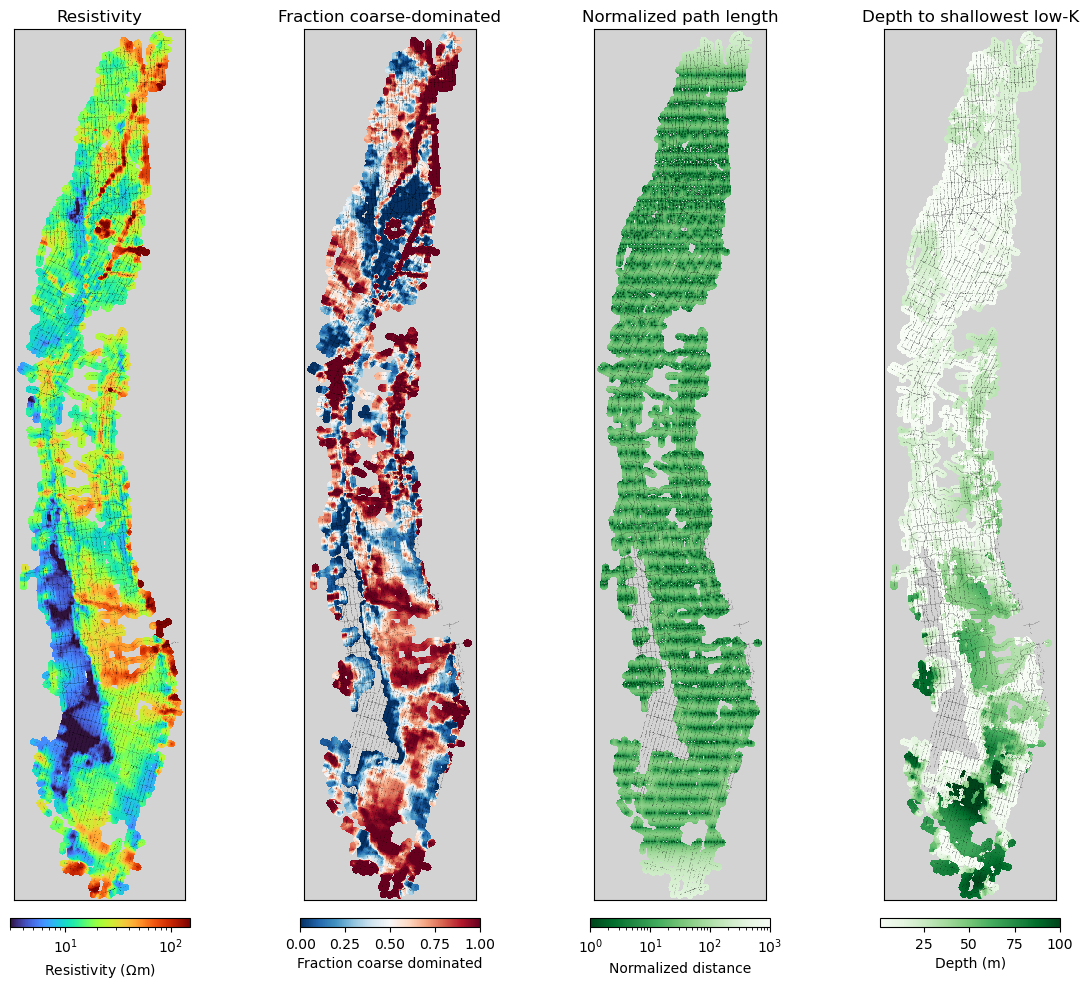

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(12, 10))
ax1, ax2, ax3, ax4 = axs
out = mesh.plot_image(
    rho_avg_idw, ax=ax1, pcolor_opts={"norm": LogNorm(vmin=3, vmax=150), "cmap": "turbo"}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.01, pad=0.02, ax=ax1)
cb.set_label("Resistivity ($\Omega$m)")
ax1.set_title("Resistivity")

out = mesh.plot_image(fc_idw, ax=ax2, pcolor_opts={"cmap": "RdBu_r"})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.01, pad=0.02, ax=ax2)
cb.set_label("Fraction coarse dominated")
ax2.set_title("Fraction coarse-dominated")

out = mesh.plot_image(
    path_length_50_norm, ax=ax3, pcolor_opts={"cmap": "Greens_r", "norm": LogNorm(vmin=1, vmax=1e3)}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.01, pad=0.02, ax=ax3)
cb.set_label("Normalized distance")
ax3.set_title("Normalized path length")

out = mesh.plot_image(path_to_no_flow_50, ax=ax4, clim=(1, 100), pcolor_opts={"cmap": "Greens"})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.01, pad=0.02, ax=ax4)
cb.set_label("Depth (m)")
ax4.set_title("Depth to shallowest low-K")


for ax in axs:
    ax.plot(xy_aem_rot[::10, 0], xy_aem_rot[::10, 1], "k,", alpha=0.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_aspect(1)
    ax.set_facecolor("lightgrey")
# ax.set_title("Averaged resistivity")
plt.tight_layout()
# fig.savefig('2d_metric_maps.png', dpi=300)

# Grid Transformation & Interpolation

Transform all calculated metrics back to the original coordinate system and interpolate them to a consistent grid. This section also calculates depth-stratified averages of resistivity and FCD for different depth intervals (0-10m, 10-30m, 30m to base surface) to understand vertical variations in sediment properties.

In [45]:
tree_final = kdtree(xy_grid_rot)
k_nearest_points = 10
d_final, inds_idw_final = tree_final.query(xy_grid_orig, k=int(k_nearest_points))
dx, dy = 400, 400
epsilon = np.min([dx, dy])
power = 1.0
w_final = 1.0 / ((d_final + epsilon) ** power)


def idw_interpolation(values, w, inds_idw):
    values_idw = np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1)
    return values_idw


mask_inds_final = ~distance_mask(
    (xy_aem[:, 0], xy_aem[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:, 0], xy_grid_orig[:, 1]),
)

In [46]:
mask_inds_final = ~distance_mask(
    (xy_aem[:, 0], xy_aem[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:, 0], xy_grid_orig[:, 1]),
)

In [47]:
mask_inds_final_active = ~distance_mask(
    (xy_aem_active[:, 0], xy_aem_active[:, 1]),
    maxdist=3000,
    coordinates=(xy_grid_orig[:, 0], xy_grid_orig[:, 1]),
)

In [48]:
rho_1 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type="harmonic"
)
rho_2 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type="harmonic"
)
rho_3 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 50, 30, average_type="harmonic"
)
rho_1_avg_final = idw_interpolation(rho_1, w_final, inds_idw_final)
rho_2_avg_final = idw_interpolation(rho_2, w_final, inds_idw_final)
rho_3_avg_final = idw_interpolation(rho_3, w_final, inds_idw_final)

fcd_1 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type="arithmetic"
)
fcd_2 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type="arithmetic"
)
fcd_3 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 50, 30, average_type="arithmetic"
)
fcd_1_avg_final = idw_interpolation(fcd_1, w_final, inds_idw_final)
fcd_2_avg_final = idw_interpolation(fcd_2, w_final, inds_idw_final)
fcd_3_avg_final = idw_interpolation(fcd_3, w_final, inds_idw_final)

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorCCz has been deprecated, please use TensorMesh.cell_centers_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/2801159510.py:15: RuntimeWarning: invalid value encountered in divide
  avg = 1.0 / ((1.0 / MOD * HZ).sum(axis=1) / (HZ).sum(axis=1))
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/2801159510.py:13: RuntimeWarning: invalid value encountered in divide
  avg = (MOD * HZ).sum(axis=1) / (HZ).sum(axis=1)


In [49]:
rho_avg_final = idw_interpolation(rho_avg_idw.data, w_final, inds_idw_final)

# % threshold
path_length_90_norm_final = idw_interpolation(path_length_90_norm.data, w_final, inds_idw_final)
path_to_no_flow_90_final = idw_interpolation(path_to_no_flow_90.data, w_final, inds_idw_final)

# % threshold
path_length_80_norm_final = idw_interpolation(path_length_80_norm.data, w_final, inds_idw_final)
path_to_no_flow_80_final = idw_interpolation(path_to_no_flow_80.data, w_final, inds_idw_final)

# % threshold
path_length_50_norm_final = idw_interpolation(path_length_50_norm.data, w_final, inds_idw_final)
path_to_no_flow_50_final = idw_interpolation(path_to_no_flow_50.data, w_final, inds_idw_final)

# % threshold
path_length_20_norm_final = idw_interpolation(path_length_20_norm.data, w_final, inds_idw_final)
path_to_no_flow_20_final = idw_interpolation(path_to_no_flow_20.data, w_final, inds_idw_final)

# % threshold
path_length_10_norm_final = idw_interpolation(path_length_10_norm.data, w_final, inds_idw_final)
path_to_no_flow_10_final = idw_interpolation(path_to_no_flow_10.data, w_final, inds_idw_final)

# % threshold
fc_final = idw_interpolation(fc_idw.data, w_final, inds_idw_final)

In [50]:
geoms = gpd.points_from_xy(mesh_orig.cell_centers[:, 0], mesh_orig.cell_centers[:, 1])
gdf_pts = gpd.GeoDataFrame(data={}, geometry=geoms)
gdf_pts = gdf_pts.set_crs(epsg=3310)
gdf_pts_cv = gdf_pts.clip(gdf_cv_3310)
inds_cv = np.array(list(gdf_pts_cv.index))
mask_inds_cv = np.ones(mesh_orig.n_cells, dtype=bool)
mask_inds_cv[inds_cv] = False

base_int_final = idw_interpolation(base_int.data, w_final, inds_idw_final)
base_int_final = ma.masked_array(base_int_final, mask=mask_inds_cv)

In [51]:
wt_final = idw_interpolation(wt_idw.data, w_final, inds_idw_final)
wt_final = ma.masked_array(wt_final, mask=mask_inds_cv)

In [52]:
# base_dict = {'base':base_int_final, 'mesh':mesh_orig}
# dill.dump(base_dict, open('base_dict.pik', 'wb'))

In [53]:
# rho_fine_cv_grid_idw
rho_fine_cv_grid_idw_final = idw_interpolation(rho_fine_cv_mesh, w_final, inds_idw_final)
rho_fine_cv_grid_idw_final = ma.masked_array(rho_fine_cv_grid_idw_final, mask=mask_inds_cv)

In [54]:
rho_coarse_cv_grid_idw_final = idw_interpolation(rho_coarse_cv_mesh, w_final, inds_idw_final)
rho_coarse_cv_grid_idw_final = ma.masked_array(rho_coarse_cv_grid_idw_final, mask=mask_inds_cv)

In [55]:
gdf_subbasin_cv = gpd.read_file(f"{extract_dir}/data/shp/subbasins/subbasins_cv.shp")

In [56]:
from matplotlib.colors import LogNorm
import rasterio
from rasterio.plot import show

src = rasterio.open(f"{extract_dir}/data/cv_terrain.tiff")

In [57]:
# mask_cdwr = np.load('fc_avg_cdwr_mask.npy')
# fc_avg_cdwr = np.load('fc_avg_cdwr.npy')
# fc_avg_cdwr = ma.masked_array(fc_avg_cdwr, mask=np.logical_or(mask_inds_final_active, mask_cdwr))

In [58]:
rho_avg_final = ma.masked_array(rho_avg_final, mask=mask_inds_final)

# % threshold
path_length_90_norm_final = ma.masked_array(path_length_90_norm_final, mask=mask_inds_final_active)
path_to_no_flow_90_final = ma.masked_array(path_to_no_flow_90_final, mask=mask_inds_final_active)

# % threshold
path_length_80_norm_final = ma.masked_array(path_length_80_norm_final, mask=mask_inds_final_active)
path_to_no_flow_80_final = ma.masked_array(path_to_no_flow_80_final, mask=mask_inds_final_active)

# % threshold
path_length_50_norm_final = ma.masked_array(path_length_50_norm_final, mask=mask_inds_final_active)
path_to_no_flow_50_final = ma.masked_array(path_to_no_flow_50_final, mask=mask_inds_final_active)

# % threshold
path_length_20_norm_final = ma.masked_array(path_length_20_norm_final, mask=mask_inds_final_active)
path_to_no_flow_20_final = ma.masked_array(path_to_no_flow_20_final, mask=mask_inds_final_active)

# % threshold
path_length_10_norm_final = ma.masked_array(path_length_10_norm_final, mask=mask_inds_final_active)
path_to_no_flow_10_final = ma.masked_array(path_to_no_flow_10_final, mask=mask_inds_final_active)

#
fc_final = ma.masked_array(fc_final, mask=mask_inds_final_active)

In [59]:
fc_final

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20)

In [60]:
gdf_rivers = gpd.read_file(f"{extract_dir}/data/shp/cv_rivers.geojson")
gdf_rivers_3310 = gdf_rivers.to_crs(3310)
gdf_rho_salinity = gpd.read_file(
    f"{extract_dir}/data/shp/rho_salinity_boundary/rho_salinity_boundary.shp"
)

In [61]:
# gdf_brackish = gpd.read_file("../data/water_quality/brackishwaterqualitylocation.geojson")
# gdf_fresh = gpd.read_file("../data/water_quality/freshwaterqualitylocation.geojson")
# gdf_brackish = gdf_brackish.to_crs(3310)
# gdf_fresh = gdf_fresh.to_crs(3310)
# xy_brackish = gdf_brackish[['UTMY', 'UTMX']].values
# xy_fresh = gdf_fresh[['UTMY', 'UTMX']].values

In [62]:
gdf_subbasin = gdf_subbasin_cv.clip(gdf_cv_3310)

In [63]:
subbasin_names_inactive = np.array(
    [
        "SUISUN-FAIRFIELD VALLEY",
        "REDDING AREA - SOUTH BATTLE CREEK",
        "REDDING AREA - ANDERSON",
        "REDDING AREA - ENTERPRISE",
        "REDDING AREA - MILLVILLE",
        "SACRAMENTO VALLEY - BEND",
        "SACRAMENTO VALLEY - ANTELOPE",
        "SACRAMENTO VALLEY - SOUTH YUBA",
        "SACRAMENTO VALLEY - SOUTH AMERICAN",
        "SAN JOAQUIN VALLEY - KETTLEMAN PLAIN",
        "SAN JOAQUIN VALLEY - WHITE WOLF",
        "SAN JOAQUIN VALLEY - PLEASANT VALLEY",
        "SAN JOAQUIN VALLEY - COSUMNES",
        "SAN JOAQUIN VALLEY - EAST CONTRA COSTA",
    ],
    dtype=object,
)

# Visualization

Generate comprehensive figures showing the spatial distribution of resistivity, FCD, and recharge metrics across the Central Valley. These visualizations help identify areas with high recharge potential and understand the relationship between subsurface properties and recharge suitability.


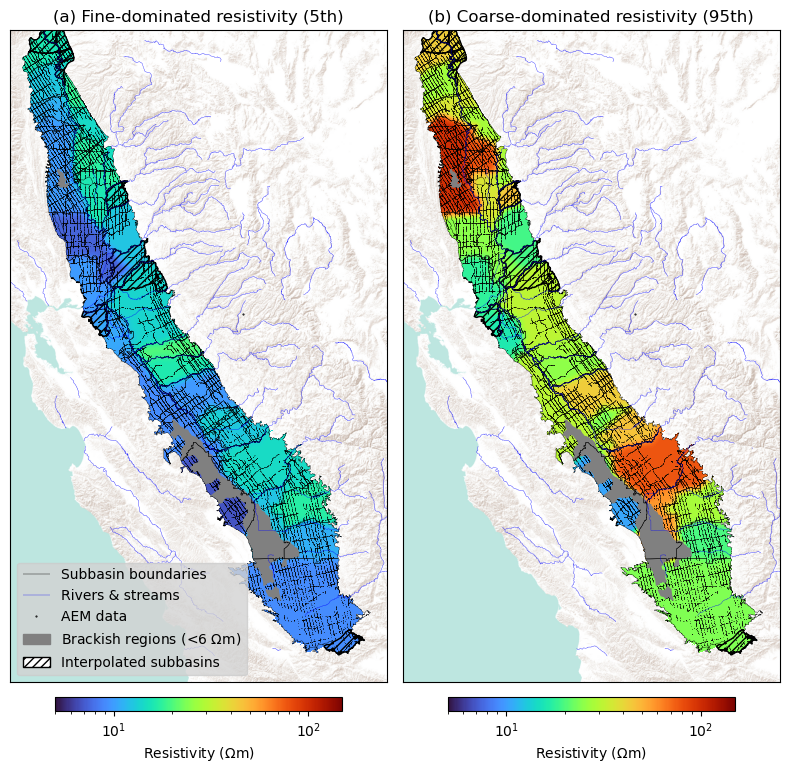

In [64]:
matplotlib.rcParams["font.size"] = 10
x = [1, 2, 4, 3, 1]
y = [1, 3, 3, 1, 1]
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
ax1, ax2 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
show(src, ax=ax1, alpha=1)
show(src, ax=ax2, alpha=1)


out = mesh_orig.plot_image(
    rho_fine_cv_grid_idw_final,
    ax=ax1,
    pcolor_opts={"norm": LogNorm(vmin=5, vmax=150), "cmap": "turbo"},
)
cb1 = plt.colorbar(out[0], ax=ax1, orientation="horizontal", fraction=0.02, pad=0.02)
out = mesh_orig.plot_image(
    rho_coarse_cv_grid_idw_final,
    ax=ax2,
    pcolor_opts={"norm": LogNorm(vmin=5, vmax=150), "cmap": "turbo"},
)
cb2 = plt.colorbar(out[0], ax=ax2, orientation="horizontal", fraction=0.02, pad=0.02)
cb1.set_label("Resistivity ($\Omega$m)")
cb2.set_label("Resistivity ($\Omega$m)")


for ii, ax in enumerate([ax1, ax2]):
    gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="Subbasin boundaries")
    gdf_basins_3310_cv.set_index("Basin_Su_1", inplace=False).loc[subbasin_names_inactive].plot(
        ax=ax, color="None", hatch="////"
    )
    gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
    gdf_rivers_3310.plot(color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM data", ms=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_aspect(1)
    ax.set_facecolor("lightgrey")
ax1.fill(x, y, color="grey", label="Brackish regions (<6 $\Omega$m)")
ax1.fill_between(
    (0, 0), (1, 1), color="w", hatch="////", label="Interpolated subbasins", edgecolors="k"
)
ax1.legend(loc=3, facecolor="lightgrey")
ax1.set_title("(a) Fine-dominated resistivity (5th)")
ax2.set_title("(b) Coarse-dominated resistivity (95th)")
plt.tight_layout()
plt.show()
fig.savefig("../figures/valley_wide_rock_physics.png", dpi=300)

In [65]:
rho_1 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type="harmonic"
)
rho_2 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type="harmonic"
)
rho_3 = calcluate_vertical_average(
    rho_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 120, 30, average_type="harmonic"
)
rho_1_avg_final = idw_interpolation(rho_1, w_final, inds_idw_final)
rho_2_avg_final = idw_interpolation(rho_2, w_final, inds_idw_final)
rho_3_avg_final = idw_interpolation(rho_3, w_final, inds_idw_final)

fcd_1 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 10, 0, average_type="arithmetic"
)
fcd_2 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data, mask_3d_final, mask_inds__active, 30, 10, average_type="arithmetic"
)
fcd_3 = calcluate_vertical_average(
    fcd_int_uniform_simpeg.data,
    mask_3d_final,
    mask_inds__active,
    120,
    30,
    average_type="arithmetic",
)
fcd_1_avg_final = idw_interpolation(fcd_1, w_final, inds_idw_final)
fcd_2_avg_final = idw_interpolation(fcd_2, w_final, inds_idw_final)
fcd_3_avg_final = idw_interpolation(fcd_3, w_final, inds_idw_final)

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorCCz has been deprecated, please use TensorMesh.cell_centers_z. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/2801159510.py:15: RuntimeWarning: invalid value encountered in divide
  avg = 1.0 / ((1.0 / MOD * HZ).sum(axis=1) / (HZ).sum(axis=1))
/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/2801159510.py:13: RuntimeWarning: invalid value encountered in divide
  avg = (MOD * HZ).sum(axis=1) / (HZ).sum(axis=1)


In [66]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    (0, 0.5, 0),  # Green
    (1, 1, 1),
]  # White
positions = [0, 1]
green_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

colors = [
    (1, 1, 1),  # Green
    (0, 0.5, 0),
]  # White
positions = [0, 1]
green_r_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

# Extract RGB values from the predefined RdBu colormap
cmap = plt.get_cmap("RdBu")

# Create a list of colors by sampling the colormap
colors = [cmap(i) for i in range(cmap.N)]

# Create the custom colormap
custom_rdbu = LinearSegmentedColormap.from_list("custom_rdbu", np.array(colors)[20:-20][::-1])

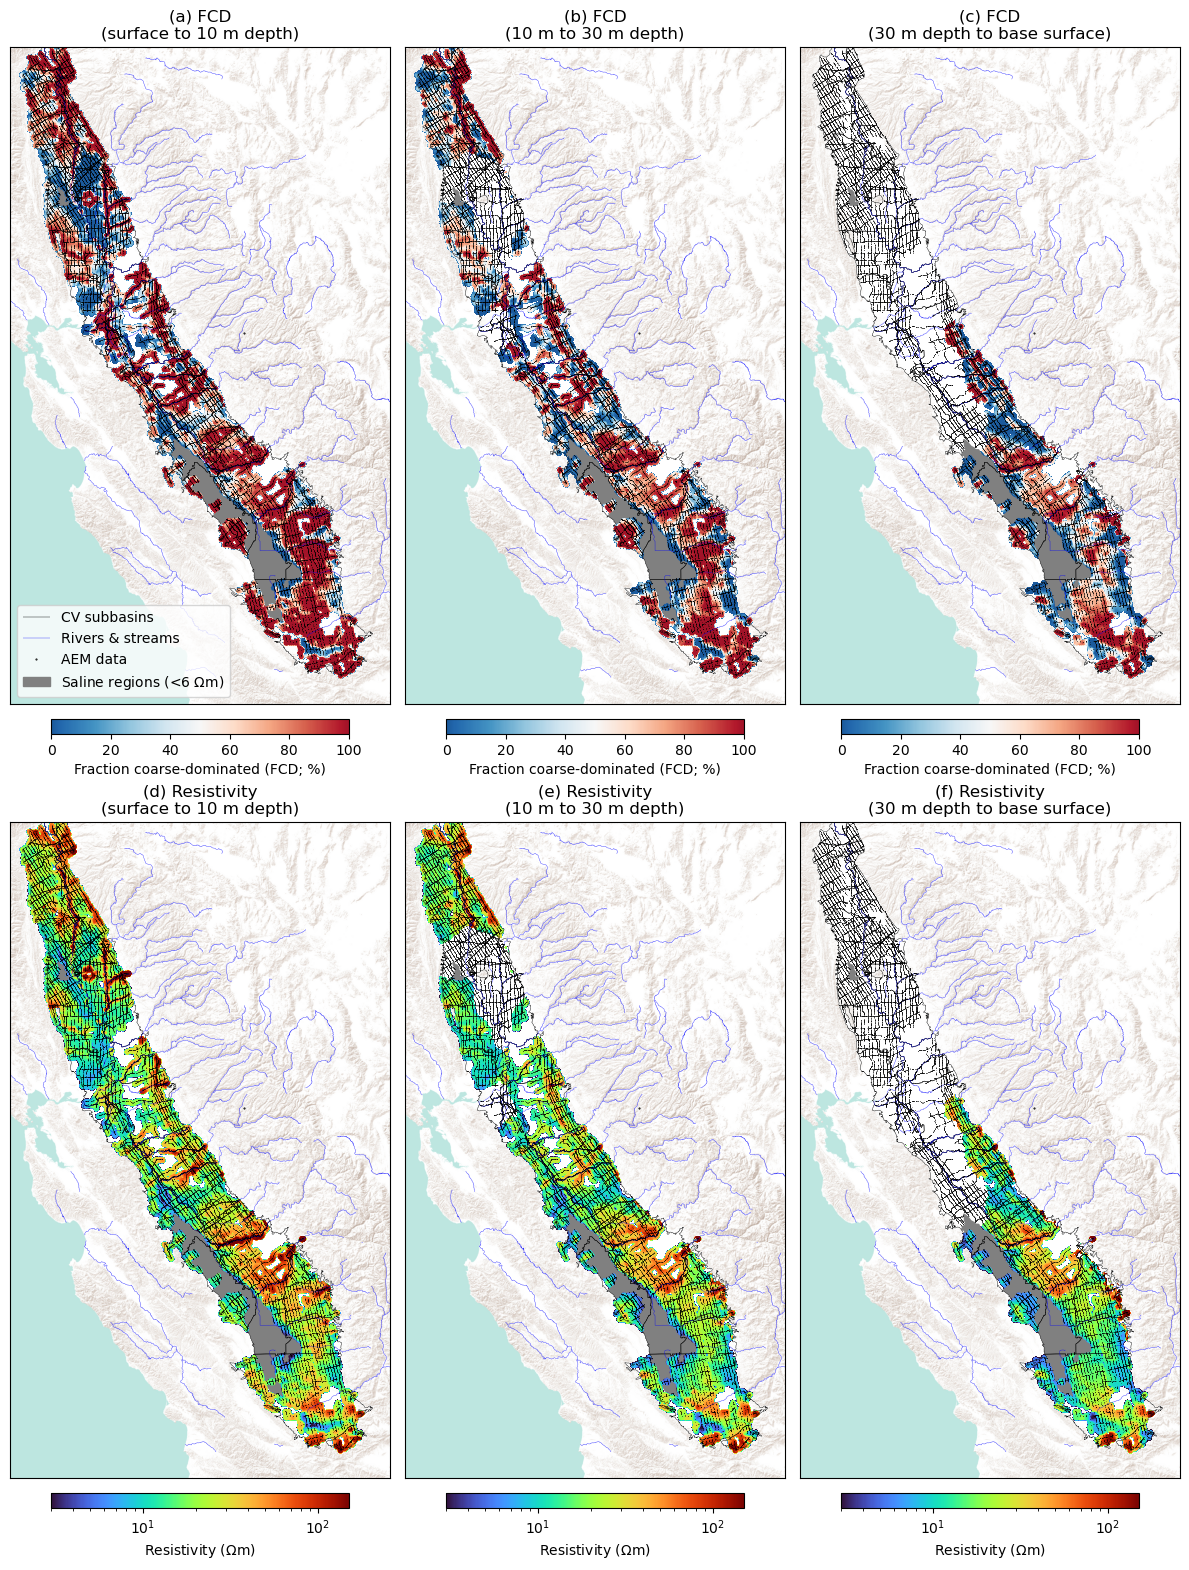

In [67]:
matplotlib.rcParams["font.size"] = 10

fig, axs = plt.subplots(2, 3, figsize=(12, 16))
ax1, ax2, ax3 = axs[0, :]
ax4, ax5, ax6 = axs[1, :]
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for tmp in axs:
    for ax in tmp:
        show(src, ax=ax, alpha=1)

out = mesh_orig.plot_image(
    rho_1_avg_final, ax=ax4, pcolor_opts={"norm": LogNorm(vmin=3, vmax=150), "cmap": "turbo"}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Resistivity ($\Omega$m)")
ax4.set_title("Resistivity")

out = mesh_orig.plot_image(
    rho_2_avg_final, ax=ax5, pcolor_opts={"norm": LogNorm(vmin=3, vmax=150), "cmap": "turbo"}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax5)
cb.set_label("Resistivity ($\Omega$m)")
ax5.set_title("Resistivity")

out = mesh_orig.plot_image(
    rho_3_avg_final, ax=ax6, pcolor_opts={"norm": LogNorm(vmin=3, vmax=150), "cmap": "turbo"}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax6)
cb.set_label("Resistivity ($\Omega$m)")
ax6.set_title("Resistivity")

out = mesh_orig.plot_image(fcd_1_avg_final * 100, ax=ax1, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax1.set_title("FCD")

out = mesh_orig.plot_image(fcd_2_avg_final * 100, ax=ax2, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax2.set_title("FCD")

out = mesh_orig.plot_image(fcd_3_avg_final * 100, ax=ax3, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Fraction coarse-dominated (FCD; %)")
ax3.set_title("FCD")


for tmp in axs:
    for ax in tmp:
        gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="CV subbasins")
        gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
        gdf_rivers_3310.plot(
            color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams"
        )
        ax.plot(0, 0, "k.", label="AEM data", ms=1)
        ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        # ax.axis('off')
        ax.set_aspect(1)
        ax.set_facecolor("lightgrey")
ax1.fill(x, y, color="grey", label="Saline regions (<6 $\Omega$m)")
ax1.legend(loc=3)
ax1.set_title("(a) FCD\n(surface to 10 m depth)")
ax2.set_title("(b) FCD\n(10 m to 30 m depth)")
ax3.set_title("(c) FCD\n(30 m depth to base surface)")
ax4.set_title("(d) Resistivity\n(surface to 10 m depth)")
ax5.set_title("(e) Resistivity\n(10 m to 30 m depth)")
ax6.set_title("(f) Resistivity\n(30 m depth to base surface)")

plt.tight_layout()
plt.show()
fig.savefig("../figures/2d_rho_fcd_maps.png", dpi=300)

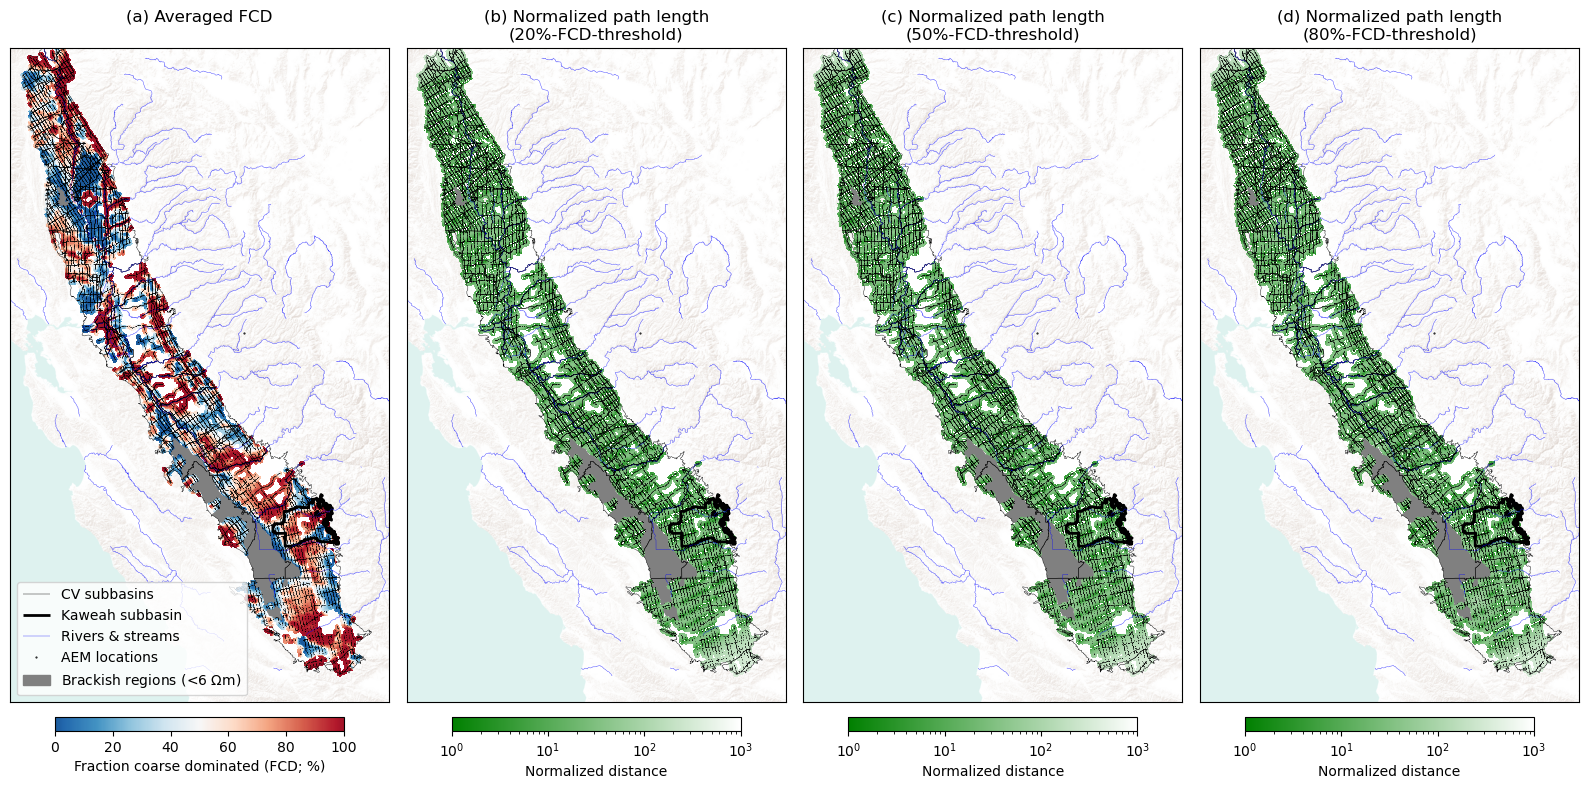

In [68]:
import matplotlib

matplotlib.rcParams["font.size"] = 10

fig, axs = plt.subplots(1, 4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)


out = mesh_orig.plot_image(fc_final * 100, ax=ax1, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(
    path_length_20_norm_final,
    ax=ax2,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_length_50_norm_final,
    ax=ax3,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Normalized distance")
ax3.set_title("(c) Normalized path length\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_length_80_norm_final,
    ax=ax4,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Normalized distance")
ax4.set_title("(d) Normalized path length\n(80%-FCD-threshold)")


for ax in axs:
    gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="CV subbasins")
    gdf_subbasin_cv.set_index("Basin_Su_1").loc[["SAN JOAQUIN VALLEY - KAWEAH"]].boundary.plot(
        color="k", label="Kaweah subbasin", ax=ax, linewidth=2
    )
    gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM locations", ms=1)
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color="grey", label="Brackish regions (<6 $\Omega$m)")
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig("../figures/2d_metric_path_length.png", dpi=300)

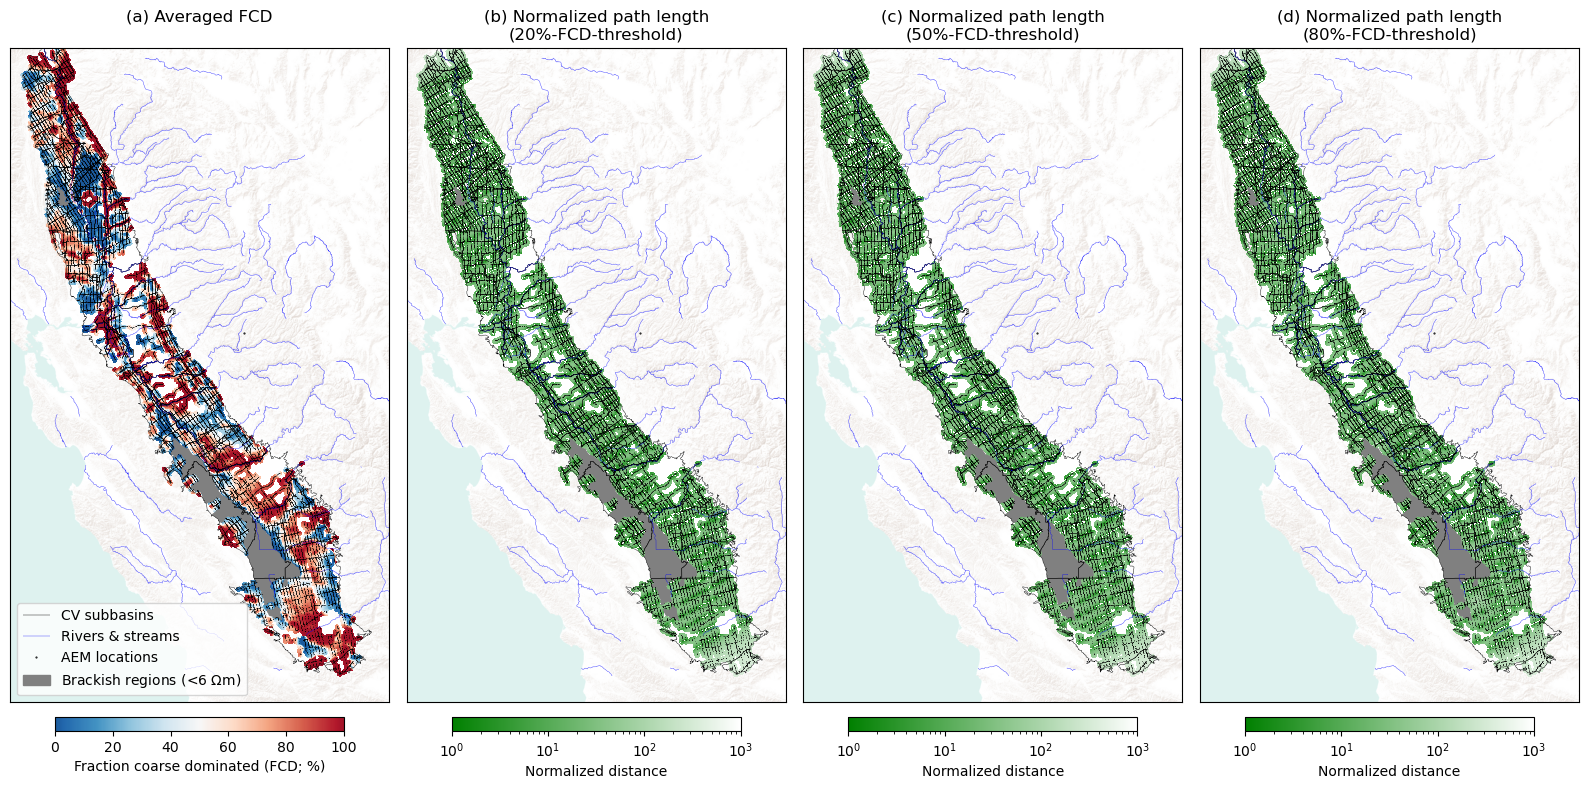

In [69]:
import matplotlib

matplotlib.rcParams["font.size"] = 10

fig, axs = plt.subplots(1, 4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)


out = mesh_orig.plot_image(fc_final * 100, ax=ax1, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(
    path_length_20_norm_final,
    ax=ax2,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_length_50_norm_final,
    ax=ax3,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Normalized distance")
ax3.set_title("(c) Normalized path length\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_length_80_norm_final,
    ax=ax4,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Normalized distance")
ax4.set_title("(d) Normalized path length\n(80%-FCD-threshold)")


for ax in axs:
    gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="CV subbasins")
    # gdf_subbasin_cv.set_index('Basin_Su_1').loc[['SAN JOAQUIN VALLEY - KAWEAH']].boundary.plot(color='k', label='Kaweah subbasin', ax=ax, linewidth=2)
    gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM locations", ms=1)
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color="grey", label="Brackish regions (<6 $\Omega$m)")
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig("../figures/2d_metric_path_length_tmp.png", dpi=300)

In [70]:
gdf_kaweah = gdf_subbasin_cv.set_index("Basin_Su_1").loc[["SAN JOAQUIN VALLEY - KAWEAH"]]

In [71]:
xmin_kaweah, xmax_kaweah = gdf_kaweah.bounds.values[0][[0, 2]]
ymin_kaweah, ymax_kaweah = gdf_kaweah.bounds.values[0][[1, 3]]

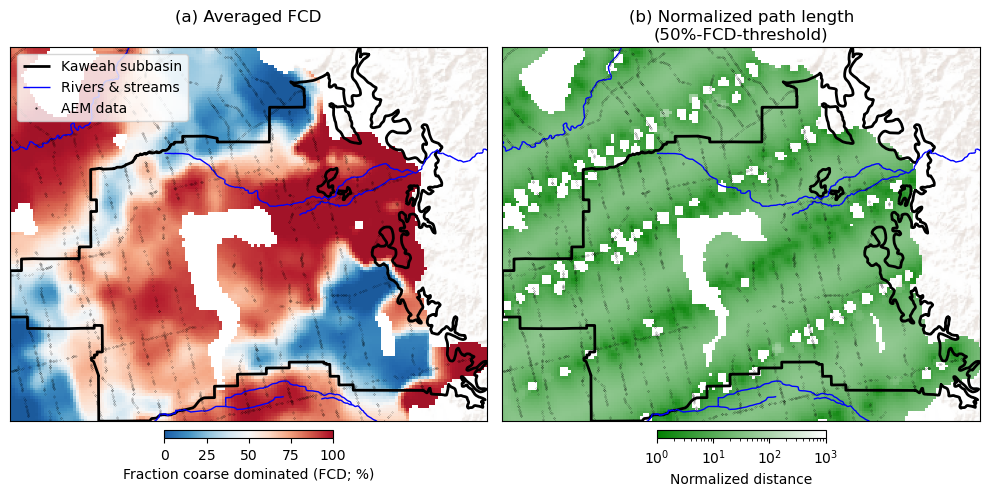

In [72]:
# | label: fig:6

matplotlib.rcParams["font.size"] = 10
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs
xlim = (xmin_kaweah, xmax_kaweah)
ylim = (ymin_kaweah, ymax_kaweah)
for ax in axs:
    show(src, ax=ax, alpha=0.5)

out = mesh_orig.plot_image(fc_final * 100, ax=ax1, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(
    path_length_50_norm_final,
    ax=ax2,
    pcolor_opts={"cmap": green_map, "norm": LogNorm(vmin=1, vmax=1000)},
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Normalized distance")
ax2.set_title("(b) Normalized path length\n(50%-FCD-threshold)")


for ax in axs:
    # gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV subbasins')
    gdf_subbasin_cv.set_index("Basin_Su_1").loc[["SAN JOAQUIN VALLEY - KAWEAH"]].boundary.plot(
        color="k", label="Kaweah subbasin", ax=ax, linewidth=2
    )
    # gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color="blue", linewidth=1, ax=ax, alpha=1, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "ko", ms=0.1, mfc="k")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.legend(loc=2)
plt.tight_layout()
fig.savefig("../figures/2d_metric_path_length_kaweah.png", dpi=300)

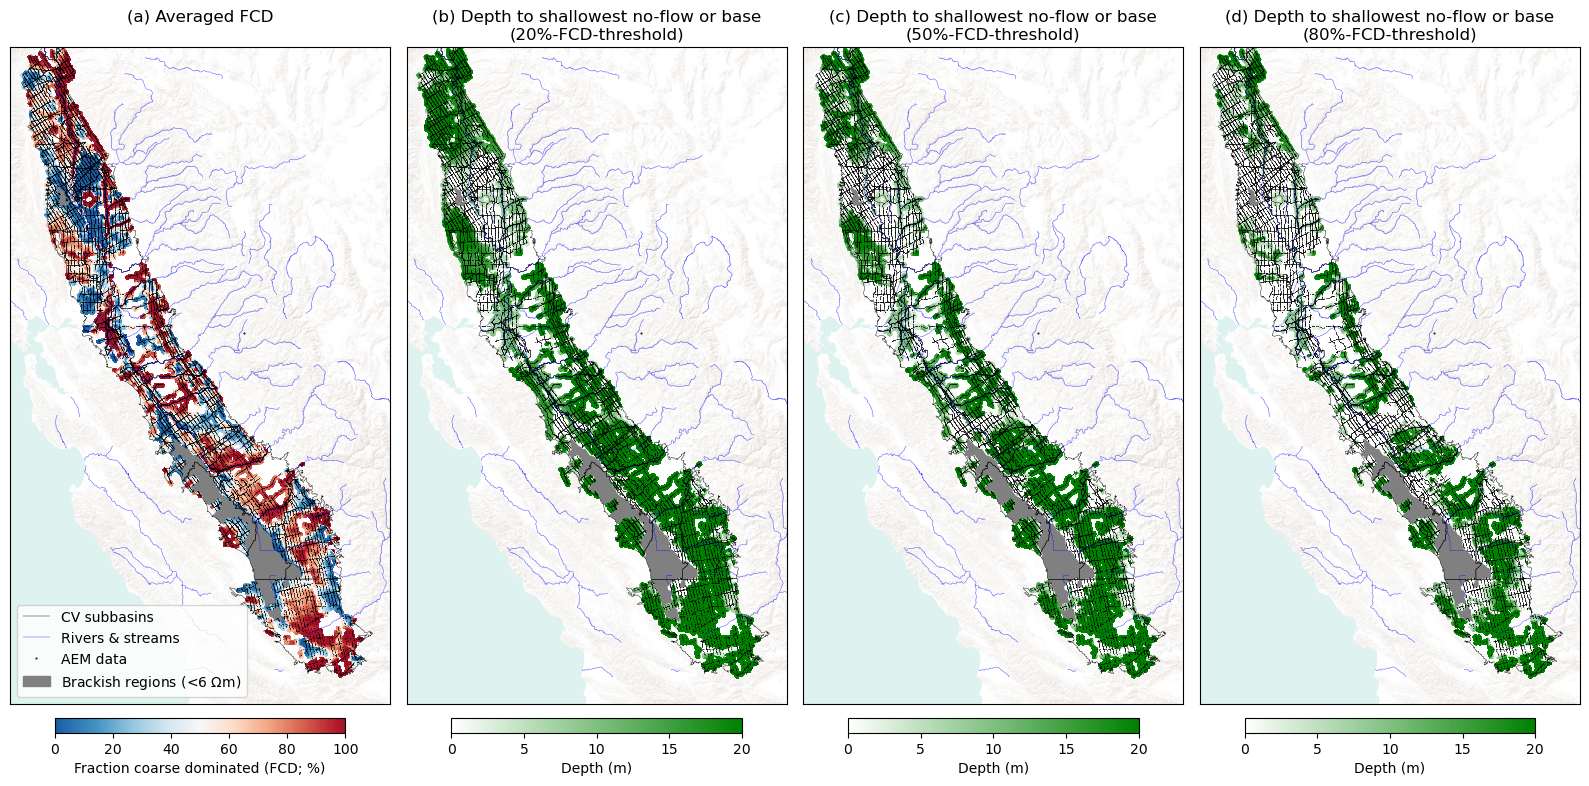

In [73]:
import matplotlib

matplotlib.rcParams["font.size"] = 10

fig, axs = plt.subplots(1, 4, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)


out = mesh_orig.plot_image(fc_final * 100, ax=ax1, pcolor_opts={"cmap": custom_rdbu})
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_label("Fraction coarse dominated (FCD; %)")
ax1.set_title("(a) Averaged FCD\n")

out = mesh_orig.plot_image(
    path_to_no_flow_20_final, ax=ax2, pcolor_opts={"clim": (0, 20), "cmap": green_r_map}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_label("Depth (m)")
ax2.set_title("(b) Depth to shallowest no-flow or base\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_to_no_flow_50_final, ax=ax3, pcolor_opts={"clim": (0, 20), "cmap": green_r_map}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax3)
cb.set_label("Depth (m)")
ax3.set_title("(c) Depth to shallowest no-flow or base\n(50%-FCD-threshold)")

out = mesh_orig.plot_image(
    path_to_no_flow_80_final, ax=ax4, pcolor_opts={"clim": (0, 20), "cmap": green_r_map}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax4)
cb.set_label("Depth (m)")
ax4.set_title("(d) Depth to shallowest no-flow or base\n(80%-FCD-threshold)")


for ax in axs:
    gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="CV subbasins")
    gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color="grey", label="Brackish regions (<6 $\Omega$m)")
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig("../figures/2d_metric_depth_to_shallowest.png", dpi=300)

In [74]:
thres_path_length_norm = 50.0
thres_path_to_no_flow = 10.0
#
inds_all = np.logical_and(
    fc_final.data > 0.8,
    path_length_80_norm_final.data < thres_path_length_norm,
    path_to_no_flow_80_final.data > thres_path_to_no_flow,
)
final_binary_metric_up = inds_all.astype(float)
final_binary_metric_up = ma.masked_array(data=final_binary_metric_up, mask=fc_final.mask)

#
inds_all = np.logical_and(
    fc_final.data > 0.5,
    path_length_50_norm_final.data < thres_path_length_norm,
    path_to_no_flow_50_final.data > thres_path_to_no_flow,
)
final_binary_metric_mid = inds_all.astype(float)
final_binary_metric_mid = ma.masked_array(data=final_binary_metric_mid, mask=fc_final.mask)

#
inds_all = np.logical_and(
    fc_final.data > 0.2,
    path_length_20_norm_final.data < thres_path_length_norm,
    path_to_no_flow_20_final.data > thres_path_to_no_flow,
)
final_binary_metric_low = inds_all.astype(float)
final_binary_metric_low = ma.masked_array(data=final_binary_metric_low, mask=fc_final.mask)

In [75]:
mesh_orig.write_UBC("./data_intermediate/mesh_orig.msh")

In [76]:
path_length_norm_list = [
    path_length_10_norm_final,
    path_length_20_norm_final,
    path_length_50_norm_final,
    path_length_80_norm_final,
    path_length_90_norm_final,
]

path_to_no_flow_list = [
    path_to_no_flow_10_final,
    path_to_no_flow_20_final,
    path_to_no_flow_50_final,
    path_to_no_flow_80_final,
    path_to_no_flow_90_final,
]
fc_thresholds = [0.1, 0.2, 0.5, 0.8, 0.9]
output_dict = {
    "fc": fc_final,
    "fc_thresholds": fc_thresholds,
    "path_length_norm": {},
    "path_to_no_flow": {},
}
for ii, thres in enumerate(fc_thresholds):
    output_dict["path_length_norm"][thres] = path_length_norm_list[ii]
    output_dict["path_to_no_flow"][thres] = path_to_no_flow_list[ii]
dill.dump(output_dict, open("./data_intermediate/output_metric_maps.pik", "wb"))

In [77]:
import matplotlib.colors

binary_cmap = matplotlib.colors.ListedColormap(["white", "green"])

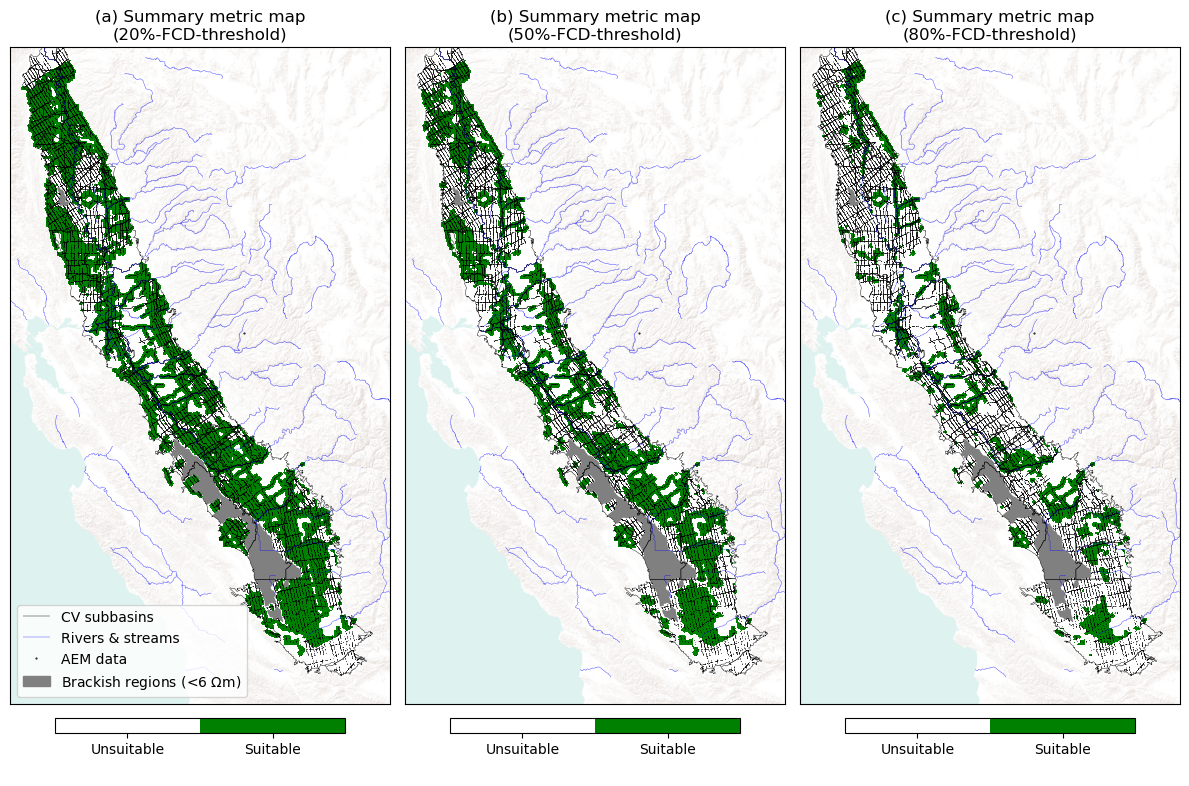

In [78]:
import matplotlib

matplotlib.rcParams["font.size"] = 10

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
ax1, ax2, ax3 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
for ax in axs:
    show(src, ax=ax, alpha=0.5)


out = mesh_orig.plot_image(
    final_binary_metric_low, ax=ax1, pcolor_opts={"clim": (0, 1), "cmap": binary_cmap}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax1)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax1.set_title("(a) Summary metric map\n(20%-FCD-threshold)")

out = mesh_orig.plot_image(
    final_binary_metric_mid, ax=ax2, pcolor_opts={"clim": (0, 1), "cmap": binary_cmap}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax2)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax2.set_title("(b) Summary metric map\n(50%-FCD-threshold)")


out = mesh_orig.plot_image(
    final_binary_metric_up, ax=ax3, pcolor_opts={"clim": (0, 1), "cmap": binary_cmap}
)
cb = plt.colorbar(out[0], orientation="horizontal", fraction=0.02, pad=0.02, ax=ax3)
cb.set_ticks([0.25, 0.75])
cb.set_ticklabels(["Unsuitable", "Suitable"])
cb.set_label(" ")
ax3.set_title("(c) Summary metric map\n(80%-FCD-threshold)")


for ax in axs:
    gdf_subbasin_cv.boundary.plot(color="k", linewidth=0.3, ax=ax, label="CV subbasins")
    gdf_rho_salinity.plot(ax=ax, legend=True, color="grey")
    # gdf_cv_3310.boundary.plot(color='k', linewidth=0.3, ax=ax, label='CV boundary')
    gdf_rivers_3310.plot(color="blue", linewidth=0.3, ax=ax, alpha=0.8, label="Rivers & streams")
    ax.plot(0, 0, "k.", label="AEM data", ms=1)
    ax.plot(xy_aem_active[::5, 0], xy_aem_active[::5, 1], "k,", alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)
ax1.fill(x, y, color="grey", label="Brackish regions (<6 $\Omega$m)")
ax1.legend(loc=3)
plt.tight_layout()
plt.show()
fig.savefig("../figures/2d_summary_maps.png", dpi=300)

# Data Export

Export all calculated metric maps as GeoTIFF files for use in GIS applications and downstream analysis. The exported files include FCD maps, path length metrics, depth-to-barrier maps, and summary suitability maps.


In [79]:
from emrecharge.gis import export_to_tif

In [80]:
nx = mesh_orig.vnC[0]
ny = mesh_orig.vnC[1]
dx = mesh_orig.h[0][0]
dy = mesh_orig.h[1][0]

xmin = mesh_orig.x0[0] + dx
ymin = mesh_orig.x0[1] + dy
crs = 3310

In [81]:
values = fc_final.data.copy()
values[fc_final.mask] = np.nan
filename = "../metric_maps/cv_fcd_aem"
export_to_tif(values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin, crs, f"{filename}.tif")

In [82]:
paths = [path_length_20_norm_final, path_length_50_norm_final, path_length_80_norm_final]
path_to_no_flows = [path_to_no_flow_20_final, path_to_no_flow_50_final, path_to_no_flow_80_final]
summaries = [
    final_binary_metric_low,
    final_binary_metric_mid,
    final_binary_metric_up,
]
thres_names = ["20", "50", "80"]

In [83]:
for ii, path in enumerate(paths):
    values = np.log10(path.data.copy())
    values[path.mask] = np.nan
    filename = "../metric_maps/cv_path_length_aem"
    export_to_tif(
        values.reshape((nx, ny), order="F").T,
        dx,
        dy,
        xmin,
        ymin,
        crs,
        f"{filename}_{thres_names[ii]}.tif",
    )

/var/folders/3b/rlk8rxgs1xx44kmtzfrwlvth0000gn/T/ipykernel_59180/1505475113.py:2: RuntimeWarning: invalid value encountered in log10
  values = np.log10(path.data.copy())


In [84]:
for ii, path in enumerate(path_to_no_flows):
    values = path.data.copy()
    values[path.mask] = np.nan
    filename = "../metric_maps/cv_path_to_no_flow_aem"
    export_to_tif(
        values.reshape((nx, ny), order="F").T,
        dx,
        dy,
        xmin,
        ymin,
        crs,
        f"{filename}_{thres_names[ii]}.tif",
    )

In [85]:
for ii, path in enumerate(summaries):
    values = path.data.copy()
    values[path.mask] = np.nan
    filename = "../metric_maps/cv_summary"
    export_to_tif(
        values.reshape((nx, ny), order="F").T,
        dx,
        dy,
        xmin,
        ymin,
        crs,
        f"{filename}_{thres_names[ii]}.tif",
    )

In [86]:
values = base_int_final.data.copy()
values[base_int_final.mask] = np.nan
filename = "../metric_maps/cv_base"
export_to_tif(
    values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin + dy, crs, f"{filename}.tif"
)

In [87]:
values = wt_final.data.copy()
values[wt_final.mask] = np.nan
filename = "../metric_maps/cv_wt"
export_to_tif(
    values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin + dy, crs, f"{filename}.tif"
)

In [88]:
values = np.log10(rho_avg_final.data.copy())
values[rho_avg_final.mask] = np.nan
filename = "../metric_maps/cv_rho"
export_to_tif(values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin, crs, f"{filename}.tif")

In [89]:
values = fcd_1_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = "../metric_maps/fcd_avg_surface_to_10m"
export_to_tif(values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin, crs, f"{filename}.tif")

In [90]:
values = fcd_2_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = "../metric_maps/fcd_avg_10m_to_30m"
export_to_tif(values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin, crs, f"{filename}.tif")

In [91]:
values = fcd_3_avg_final.data.copy()
values[rho_avg_final.mask] = np.nan
filename = "../metric_maps/fcd_avg_30m_to_base"
export_to_tif(values.reshape((nx, ny), order="F").T, dx, dy, xmin, ymin, crs, f"{filename}.tif")

## Converting + Saving all data needed for interactive visualization

**Steps**:
- RasterData: 
    - Convert numpy arrays into xarray objects (named dimensions are easier to parse)
    - Stack different parameters (here thresholds) into a labled xarray dimension for the same variable
    - Reshape the flat xy data to 2+ dimensional arrays
    - Apply reprojection
    - Write to zarr (cloud optimized format, increases portability, retains xarray metadata)
        - With this we could potentially build visualization that does not need a running jupyter kernel in the future

In [92]:
import xarray as xr

vector_space_dim = "dim_xy"
threshold_dim = "threshold"
fraction_coarse = xr.DataArray(output_dict["fc"], dims=[vector_space_dim])

# stack the fraction_threshold value as a new dimension
stacked_vars = {
    name: xr.concat(
        [
            xr.DataArray(values, dims=[vector_space_dim]).expand_dims(threshold=[th])
            for th, values in output_dict[name].items()
        ],
        dim=threshold_dim,
    )
    for name in output_dict.keys()
    if name not in ["fc", "fc_thresholds"]
}

ds = xr.Dataset({"fraction_coarse": fraction_coarse, **stacked_vars})

## fix percentage values (one could use pint-xarray here, but that is overkill for now IMO)
ds["threshold"] = ds["threshold"] * 100
ds["threshold"].attrs = {"Units": "%"}

ds["fraction_coarse"] = ds["fraction_coarse"] * 100
ds["fraction_coarse"].attrs = {"Units": "%"}
ds

<xarray.Dataset> Size: 124MB
Dimensions:           (dim_xy: 1410149, threshold: 5)
Coordinates:
  * threshold         (threshold) float64 40B 10.0 20.0 50.0 80.0 90.0
Dimensions without coordinates: dim_xy
Data variables:
    fraction_coarse   (dim_xy) float64 11MB nan nan nan nan ... nan nan nan nan
    path_length_norm  (threshold, dim_xy) float64 56MB nan nan nan ... nan nan
    path_to_no_flow   (threshold, dim_xy) float64 56MB nan nan nan ... nan nan

In [93]:
# Use a ufunc to convert the entire xarray dataset to raster format
# more info here: https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html


def convert_to_raster_ufunc(xy_array):
    return mesh_orig.reshape(xy_array.T, "CC", "CC", "M")


ds_raster = xr.apply_ufunc(
    convert_to_raster_ufunc,
    ds,
    input_core_dims=[[vector_space_dim]],
    output_core_dims=[["x", "y"]],
    vectorize=True,
)
ds_raster = ds_raster.assign_coords(
    {
        "x": mesh_orig.cell_centers_x,
        "y": mesh_orig.cell_centers_y,
    }
)

# Some values are -inf in the path_length_norm, messing with the plotting.
# Lets set them to nan for now
ds_raster = ds_raster.where(ds_raster.pipe(np.isfinite), other=np.nan)

ds_raster

<xarray.Dataset> Size: 124MB
Dimensions:           (x: 871, y: 1619, threshold: 5)
Coordinates:
  * x                 (x) float64 7kB -2.269e+05 -2.265e+05 ... 1.211e+05
  * y                 (y) float64 13kB -3.482e+05 -3.478e+05 ... 2.99e+05
  * threshold         (threshold) float64 40B 10.0 20.0 50.0 80.0 90.0
Data variables:
    fraction_coarse   (x, y) float64 11MB nan nan nan nan ... nan nan nan nan
    path_length_norm  (threshold, x, y) float64 56MB nan nan nan ... nan nan nan
    path_to_no_flow   (threshold, x, y) float64 56MB nan nan nan ... nan nan nan

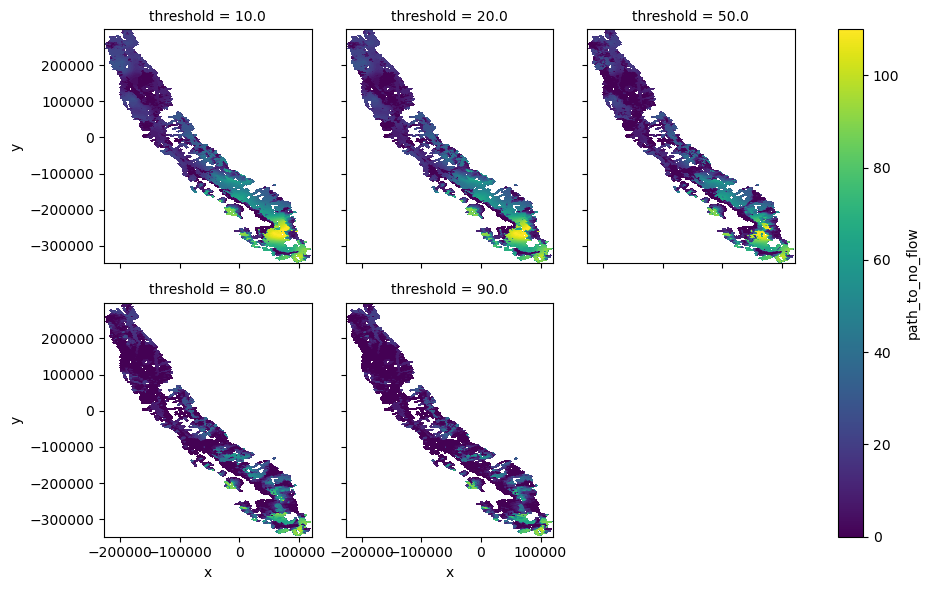

In [94]:
# a quick test plot:
ds_raster["path_to_no_flow"].plot(col=threshold_dim, x="x", y="y", col_wrap=3, cmap="viridis")

In [98]:
# Saving the zarr to the export folder (this should contain all the data needed for notebook 2)
export_dir = "./data_export"
target_epsg = 4326  # WGS84 lat/lon for web mapping

# Ensure consistent dimension ordering for visualization
ds_raster = ds_raster.transpose("threshold", "y", "x")
ds_raster = ds_raster.sortby("y", ascending=False)  # Top to bottom (north to south)
ds_raster = ds_raster.sortby("x", ascending=True)  # Left to right (west to east)

# Reproject raster from CA Albers to WGS84
ds_raster.rio.write_crs(3310, inplace=True)  # Set source CRS
ds_reprojected = ds_raster.rio.reproject(f"EPSG:{target_epsg}")
ds_reprojected.to_zarr(f"{export_dir}/consolidated_metric_output.zarr", mode="w")

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [99]:
# Finally lets save all the processed vector output to the export folder aswell

# # -------------------------------
# # Optimize Geometries for Map Performance
# # -------------------------------


def simplify_geometry(gdf, tolerance=0.001):
    gdf["geometry"] = gdf.geometry.simplify(tolerance=0.001, preserve_topology=True)
    return gdf


simplify_geometry(gdf_subbasin_cv).to_crs(epsg=target_epsg).to_file(
    f"{export_dir}/subbasin.geojson", driver="GeoJSON"
)
simplify_geometry(gdf_rho_salinity).to_crs(epsg=target_epsg).to_file(
    f"{export_dir}/brackish.geojson", driver="GeoJSON"
)
simplify_geometry(gdf_rivers_3310).to_crs(epsg=target_epsg).to_file(
    f"{export_dir}/rivers.geojson", driver="GeoJSON"
)

# omitting the measurement points due to performance constraints for now.
# # measurement points:
# lons, lats = xy_aem_active[::5,0], xy_aem_active[::5,1]
# # Convert to geometries
# geoms = [Point(lon, lat) for lon, lat in zip(lons, lats)]

# # Create GeoDataFrame
# gdf = gpd.GeoDataFrame({"lon": lons, "lat": lats}, geometry=geoms, crs="EPSG:3310").to_crs(epsg=target_epsg)

# # Write to FlatGeobuf
# gdf.to_file(f"{export_dir}/measurement_points.fgb", driver="FlatGeobuf")

In [100]:
# zip up only the exported files to commit them to the repo
! cd {export_dir} && zip -rm ../data_export.zip . 

  adding: rivers.geojson (deflated 77%)
  adding: subbasin.geojson (deflated 69%)
  adding: consolidated_metric_output.zarr/ (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/ (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/zarr.json (deflated 55%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/ (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/0/ (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/0/0 (deflated 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/0/1 (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/1/ (stored 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/1/0 (deflated 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/1/1 (deflated 0%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/1/2 (deflated 3%)
  adding: consolidated_metric_output.zarr/fraction_coarse/c/3/ (stored 0%)
  adding: consolidated_